# Небольшой шаблончик для работы с сетками

# Часть 1 - Чепоинты

In [1]:
import os
import torch

def save_checkpoint(model, optimizer, scheduler, epoch, best_score, path="checkpoint.pt"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_score": best_score
    }
    if scheduler is not None:
        checkpoint["scheduler_state"] = scheduler.state_dict()
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, scheduler=None, path="checkpoint.pt", device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    best_score = checkpoint["best_score"]
    start_epoch = checkpoint["epoch"] + 1
    if scheduler is not None and "scheduler_state" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state"])
    print(f"Loaded checkpoint from previous epochs: {checkpoint['epoch']}, best_score={best_score:.4f}")
    return start_epoch, best_score

# Часть 2 - Обучение

In [2]:
from tqdm import tqdm
import torch.nn.functional as F

def train_epoch(model, optimizer, loader, loss_fn, device, grad_clip = None, metric_fn = None):
  model.train()
  total_loss, metric_sum, total = 0.0, 0, 0

  for data, target in tqdm(loader, desc="Training", leave=False):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    predictions = model(data)
    loss = loss_fn(predictions, target)
    loss.backward()

    # В случае если хочется использовать регуляризацию значений для града
    if grad_clip is not None:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    optimizer.step()

    total_loss += loss.item() * target.size(0)

    if metric_fn is not None:
            metric_sum += metric_fn(predictions, target) * target.size(0)

    total += target.size(0)

  avg_loss = total_loss / total
  avg_metric = metric_sum / total if metric_fn is not None else None
  return avg_loss, avg_metric

In [3]:
def train(model, optimizer, n_epochs, train_loader, val_loader, device,
          loss_fn=F.cross_entropy, scheduler=None, grad_clip=None,
          checkpoint_path="best_model.pt", resume=False, metric="val_loss", save_last=True, metric_fn=None):

  if resume and os.path.exists(checkpoint_path):
        start_epoch, best_score = load_checkpoint(model, optimizer, scheduler, checkpoint_path, device)
  else:
        start_epoch, best_score = 1, (float("inf") if metric == "val_loss" else 0.0)

  train_loss_log, train_metric_log, val_loss_log, val_metric_log = [], [], [], []

  for epoch in range(1, n_epochs+1):
    print(f"\nEpoch {epoch}/{n_epochs}")

    train_loss, train_metric = train_epoch(model, optimizer, train_loader, loss_fn, device, grad_clip, metric_fn)
    val_loss, val_metric = evaluate(model, val_loader, loss_fn, device, metric_fn)

    train_loss_log.append(train_loss)
    train_metric_log.append(train_metric)
    val_loss_log.append(val_loss)
    val_metric_log.append(val_metric)

    print(f" train loss: {train_loss:.4f}, train acc: {train_metric:.4f}")
    print(f" val loss: {val_loss:.4f}, val acc: {val_metric:.4f}")

    if scheduler is not None:
      scheduler.step()

    if metric_fn is None or metric == "val_loss":
      current_score = val_loss
      improvement = current_score < best_score

    else:
      current_score = val_metric
      improvement = current_score > best_score

    if improvement:
      best_score = current_score
      save_checkpoint(model, optimizer, scheduler, epoch, best_score, checkpoint_path)
      print(f"Saved new best model ({metric}={best_score:.4f})")

    elif save_last:
      save_checkpoint(model, optimizer, scheduler, epoch, best_score, "last_model.pt")


  return train_loss_log, train_metric_log, val_loss_log, val_metric_log

In [4]:
def evaluate(model, loader, loss_fn, device, metric_fn=None):
  model.eval()
  total_loss, metric_sum, total = 0.0, 0, 0

  with torch.no_grad():
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      predictions = model(data)
      loss = loss_fn(predictions, target)
      total_loss += loss.item()*target.size(0)

      if metric_fn is not None:
              metric_sum += metric_fn(predictions, target) * target.size(0)

      total += target.size(0)

  avg_loss = total_loss/total
  avg_metric = metric_sum / total if metric_fn is not None else None
  return avg_loss, avg_metric

In [5]:
# В качестве примеров

def accuracy(predictions, target):
    return (predictions.argmax(dim=1) == target).float().mean().item()

def binary_accuracy(predictions, target):
    preds = (torch.sigmoid(predictions) > 0.5).long()
    return (preds == target).float().mean().item()

def mse(predictions, target):
    return F.mse_loss(predictions, target).item()


# Часть 3 - рисовашки потерь и значения  метрики

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reses(train_loss, train_metric, val_loss, val_metric, metric_name="Metric"):

    epochs = np.arange(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    # Для loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='#1f77b4', linewidth=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.set_xticks(epochs)
    ax1.tick_params(axis='both', labelsize=10)

    # Для вашей метрики
    ax2.plot(epochs, train_metric, label=f'Train {metric_name}', color='#1f77b4', linewidth=2)
    ax2.plot(epochs, val_metric, label=f'Validation {metric_name}', color='#ff7f0e', linestyle='--', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.set_title(f'Training and Validation {metric_name}')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    ax2.set_xticks(epochs)
    ax2.tick_params(axis='both', labelsize=10)

    plt.tight_layout()
    plt.show()

# Часть 4 - Ну и небольшой примерчик как все вместе может выглядеть

In [7]:

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3)
        self.fc = nn.Linear(26*26*32, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleCNN().to(device)

transform = transforms.ToTensor()
train_data = datasets.MNIST(root=".", train=True, transform=transform, download=True)
val_data = datasets.MNIST(root=".", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_acc, val_loss, val_acc = train(
    model, optimizer, n_epochs=3,
    train_loader=train_loader, val_loader=val_loader,
    device=device, metric_fn=accuracy, metric="val_metric"
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]



Epoch 1/3


 train loss: 0.2052, train acc: 0.9409
 val loss: 0.0916, val acc: 0.9736
Saved new best model (val_metric=0.9736)

Epoch 2/3


 train loss: 0.0747, train acc: 0.9784
 val loss: 0.0805, val acc: 0.9754
Saved new best model (val_metric=0.9754)

Epoch 3/3


 train loss: 0.0506, train acc: 0.9851
 val loss: 0.0670, val acc: 0.9794
Saved new best model (val_metric=0.9794)


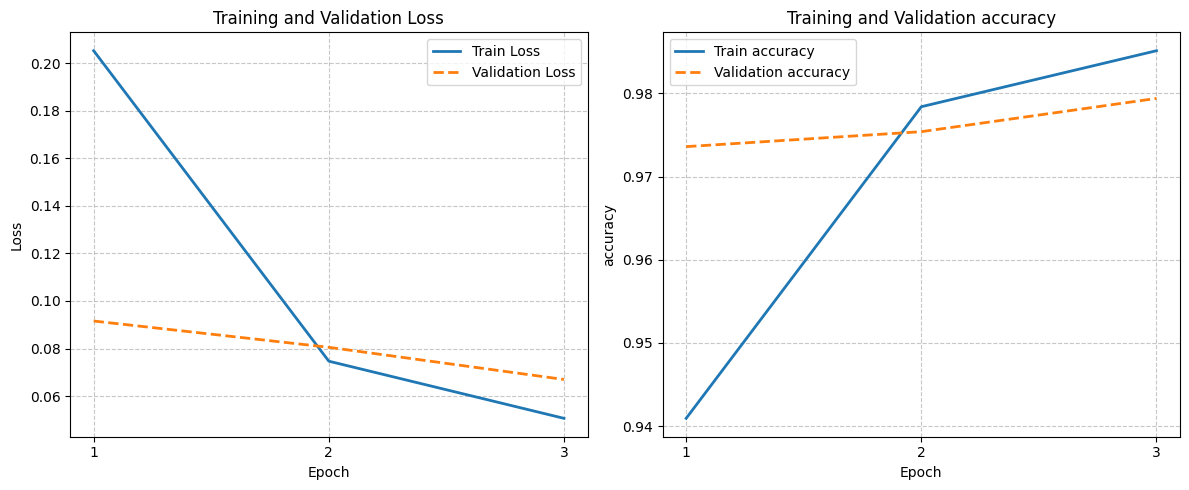

In [8]:
plot_reses(train_loss, train_acc, val_loss, val_acc, metric_name='accuracy')